# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 7: Fairness and Bias


**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2pt">

In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [2]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, roc_auc_score
)                           
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit.**

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "95% confidence interval of coefficients for degree-5 polynomial model" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

<a id="contents"></a>

## Notebook contents

- [**Required reading and data description**](#intro)


- [**Question 1: Data exploration [26 pts]**](#part1)
  - [Solutions](#part1solutions)


- [**Question 2: Baseline modeling [21 pts]**](#part2)
  - [Solutions](#part2solutions)


- [**Question 3: Predicting without using `race` [19 pts]**](#part3)
  - [Solutions](#part3solutions)


- [**Question 4: Classification thresholds and fairness [34 pts]**](#part4)
  - [Solutions](#part4solutions)

<a id="intro"></a>

## Required reading and data description

[Return to contents](#contents)

### Required reading

The required readings for this homework are two articles that report on the effectiveness of and issues surrounding the COMPAS recidivism algorithm used in U.S. courts. One article is published by ProPublica and the other by the MIT Technology Review:

1. Angwin, Julia; Larson, Jeff; Mattu, Surya; Kirchner, Lauren (2016). "Machine Bias: There’s software used across the country to predict future criminals. And it’s biased against blacks." ProPublica, May 23, 2016. https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


2. Hao, Karen; Stray, Jonathan (2019). "Can you make AI fairer than a judge? Play our courtroom algorithm game: The US criminal legal system uses predictive algorithms to try to make the judicial process less biased. But there’s a deeper problem." MIT Technology Review, October 17, 2019. https://www.technologyreview.com/2019/10/17/75285/ai-fairer-than-judge-criminal-risk-assessment-algorithm/

You will need to read these articles for the sufficient background needed to successfully complete this homework assignment. It may also be useful to refer back to content covered during the mid-semester lecture on ethics: [Lecture 13: EthiCS](https://edstem.org/us/courses/9045/lessons/23452/slides/138052).

### Data description

In this assignment, we will be analyzing a portion of the data set used by ProPublica in their report. The data are found in the `compas.csv` file and the "data dictionary", which very briefly explains each variable in the data set, can be found in the `compas_datadict.csv` file.

<a id="part1"></a>

## <div class='exercise'>Question 1: Data exploration [26 pts]</div> 
    
[Return to contents](#contents)

**1.1** What is the statistical objective of the COMPAS algorithm?  How is recidivism prediction used in courtrooms?

**1.2** Consider the information in the provided `compas_datadict.csv`.  Which variables are raw data?  Which are pre-processed data?  Which is the target variable of the COMPAS algorithm?  Which are output(s) of the COMPAS algorithm?   Which should not be used in building our own model to predict recidivism?  

**1.3** Read-in the data and split it into 80% training and 20% test **stratified by `race`** (use `random_state=50`). Before splitting, you may want to process the categorical predictors `c_charge_degree`, `race`, and `sex` first so you don't have to do it separately in train and test later.

**1.4** Now we will do a little EDA. Provide visuals to explore which **unprocessed** quantitative variables, including `decile_score` (**not** the derived binary variables or pre-processed versions of the available quantitative variables, for example), are related to `race`.

**HINT:** You may find your Question 1.4 visuals to be more legible and Question 1.5 easier to answer by grouping your non-Caucasion and non-African-American observations together as "all other" racial groups in your plots. However, if you choose to do so, this should only be a temporary grouping of those observations for plotting purposes. Your actual observations should NOT be grouped.

**1.5** Based on your visuals, report which 3 variables appear to have the most significant differences between Caucasians and African Americans. Briefly interpret your findings for each of those 3 variables, being certain to explain your justification for choosing each.

**NOTE:** As illustrated by [the required readings](#intro), reporting on the U.S. Criminal Justice system often concentrates on the disparate experiences between Caucasians and African Americans, thus we have focused our approaches similarly. However, to ensure the efficacy of our models in Question 2 and Question 3, we must be certain to still keep observations for all racial groups included in our data. 

**1.6** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?

<a id="part1solutions"></a>

## Question 1: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**1.1** What is the statistical objective of the COMPAS algorithm?  How is recidivism prediction used in courtrooms?

</div>

**The statistical objective of the COMPAS algorithm is to predict the likelihood that a defendant awaiting trial will reoffend in the future. The idea is to minimize chances of recidivism and subsequent endangerment to society. These scores are intended to help judges decide whether a defendant should be detained or released while awaiting trail by offering an assessment of the defendant's recidivism risk. Such recidivism predictions are also used by judges to inform decisions throughout the entire judicial process including pre-trial release, sentencing and parole eligibility.**

<div class='exercise-r'>

**1.2** Consider the information in the provided `compas_datadict.csv`.  Which variables are raw data?  Which are pre-processed data?  Which is the target variable of the COMPAS algorithm?  Which are output(s) of the COMPAS algorithm?   Which should not be used in building our own model to predict recidivism?

</div>

**Of the information provided in `compas_datadict.csv`, the following variables represent raw data: 'age', 'c_charge_degree', 'race', 'sex', 'length_of_stay', 'priors_count', 'juv_fel_count', 'juv_misd_count' 'juv_other_count', 'c_charge_desc'. The pre-processed variables are the following: 'length_of_stay_thresh', 'priors_1', 'priors_234', 'priors_5plus', 'juv_fel_1plus', 'juv_misd_1plus', 'juv_other_1plus', 'charge_any_drug', 'charge_any_violence_aggression', 'charge_any_theft', 'score_text and 'decile_score'. The target variable of the COMPAS algorithm is 'two_year_recid' which represents the true outcome (reality) of whether or not a defendant recidivated within 2 years. 'score_text' and 'decile_score' should not be used in building our own model to predict recidivism as these features represent the predictive output of the COMPAS model.**


<div class='exercise-r'>

**1.3** Read-in the data and split it into 80% training and 20% test **stratified by `race`** (use `random_state=50`). Before splitting, you may want to process the categorical predictors `c_charge_degree`, `race`, and `sex` first so you don't have to do it separately in train and test later.

</div>

In [3]:
# your code here

df = pd.read_csv('compas.csv')

# One hot encode categorical columns 
categorical_cols = ['c_charge_degree', 'race', 'sex']

race_dummies = pd.get_dummies(df['race'], prefix = 'Race')

sex_dummies = pd.get_dummies(df['sex'], prefix = 'Sex')

c_charge_dummies = pd.get_dummies(df['c_charge_degree'], prefix = 'Charge Degree')

df = pd.concat([df, race_dummies, sex_dummies, c_charge_dummies], axis = 1)

# Define predictors and response variable, split into train and test sets, stratify on 'race'
X = df.drop(columns = ['two_year_recid'])
y = df['two_year_recid']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50, test_size = 0.2, stratify=df['race'])


X_train = X_train.drop(columns = ['race', 'sex', 'c_charge_degree'])
X_test = X_test.drop(columns = ['race', 'sex', 'c_charge_degree'])


X_test = X_test.reset_index(drop = True)
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

scale_columns = ['age', 'length_of_stay', 'length_of_stay_thresh', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']

# Fit on the entire dataset once and scale on X_train and X_test separately 
X_train_scaler = MinMaxScaler().fit(df[scale_columns])

X_train[scale_columns] = X_train_scaler.transform(X_train[scale_columns])
X_test[scale_columns] = X_train_scaler.transform(X_test[scale_columns])

assert 'two_year_recid' not in X_train.columns

<div class='exercise-r'>

**1.4** Now we will do a little EDA. Provide visuals to explore which **unprocessed** quantitative variables, including `decile_score` (**not** the derived binary variables or pre-processed versions of the available quantitative variables, for example), are related to `race`.

**HINT:** You may find your Question 1.4 visuals to be more legible and Question 1.5 easier to answer by grouping your non-Caucasion and non-African-American observations together as "all other" racial groups in your plots. However, if you choose to do so, this should only be a temporary grouping of those observations for plotting purposes. Your actual observations should NOT be grouped.

</div>

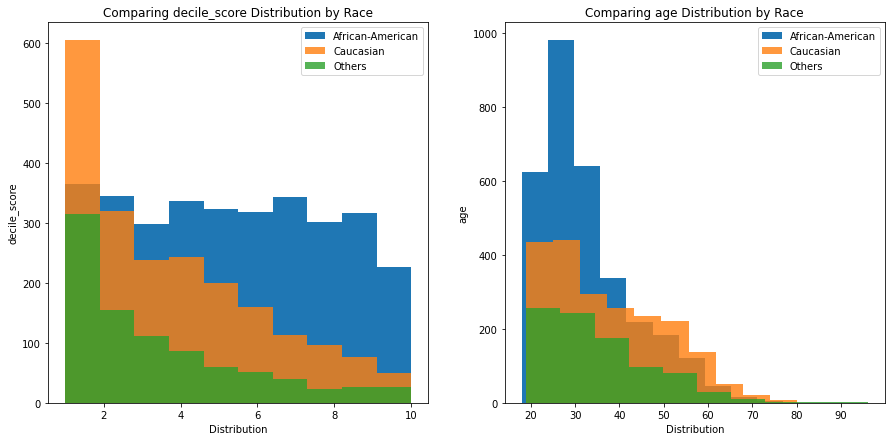

In [4]:
# your code here

def race_grouper(dataframe):
    
    return dataframe['race'] if dataframe['race'] in ['African-American', 'Caucasian'] else 'Others'

# Create a new 'race_group' column by applying a function to 'race' column
df['race_group'] = df.apply(lambda row: race_grouper(row), axis=1)

un_q_vars = ['decile_score', 'age', 'two_year_recid', 'length_of_stay', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']

fig, axes = plt.subplots(1, 2, figsize = (15,7))
axes = list(axes.flatten())

for i, var in enumerate(list(['decile_score', 'age'])):
    axes[i].set_title('Comparing '+ var + ' Distribution by Race')
    axes[i].hist(df[df['race_group']=='African-American'][var], label = 'African-American')
    axes[i].hist(df[df['race_group']=='Caucasian'][var], alpha = .8, label = 'Caucasian')
    axes[i].hist(df[df['race_group']=='Others'][var], alpha = .8, label = 'Others')
    axes[i].set_xlabel("Distribution")
    axes[i].set_ylabel(var)
    axes[i].legend()

plt.show()   



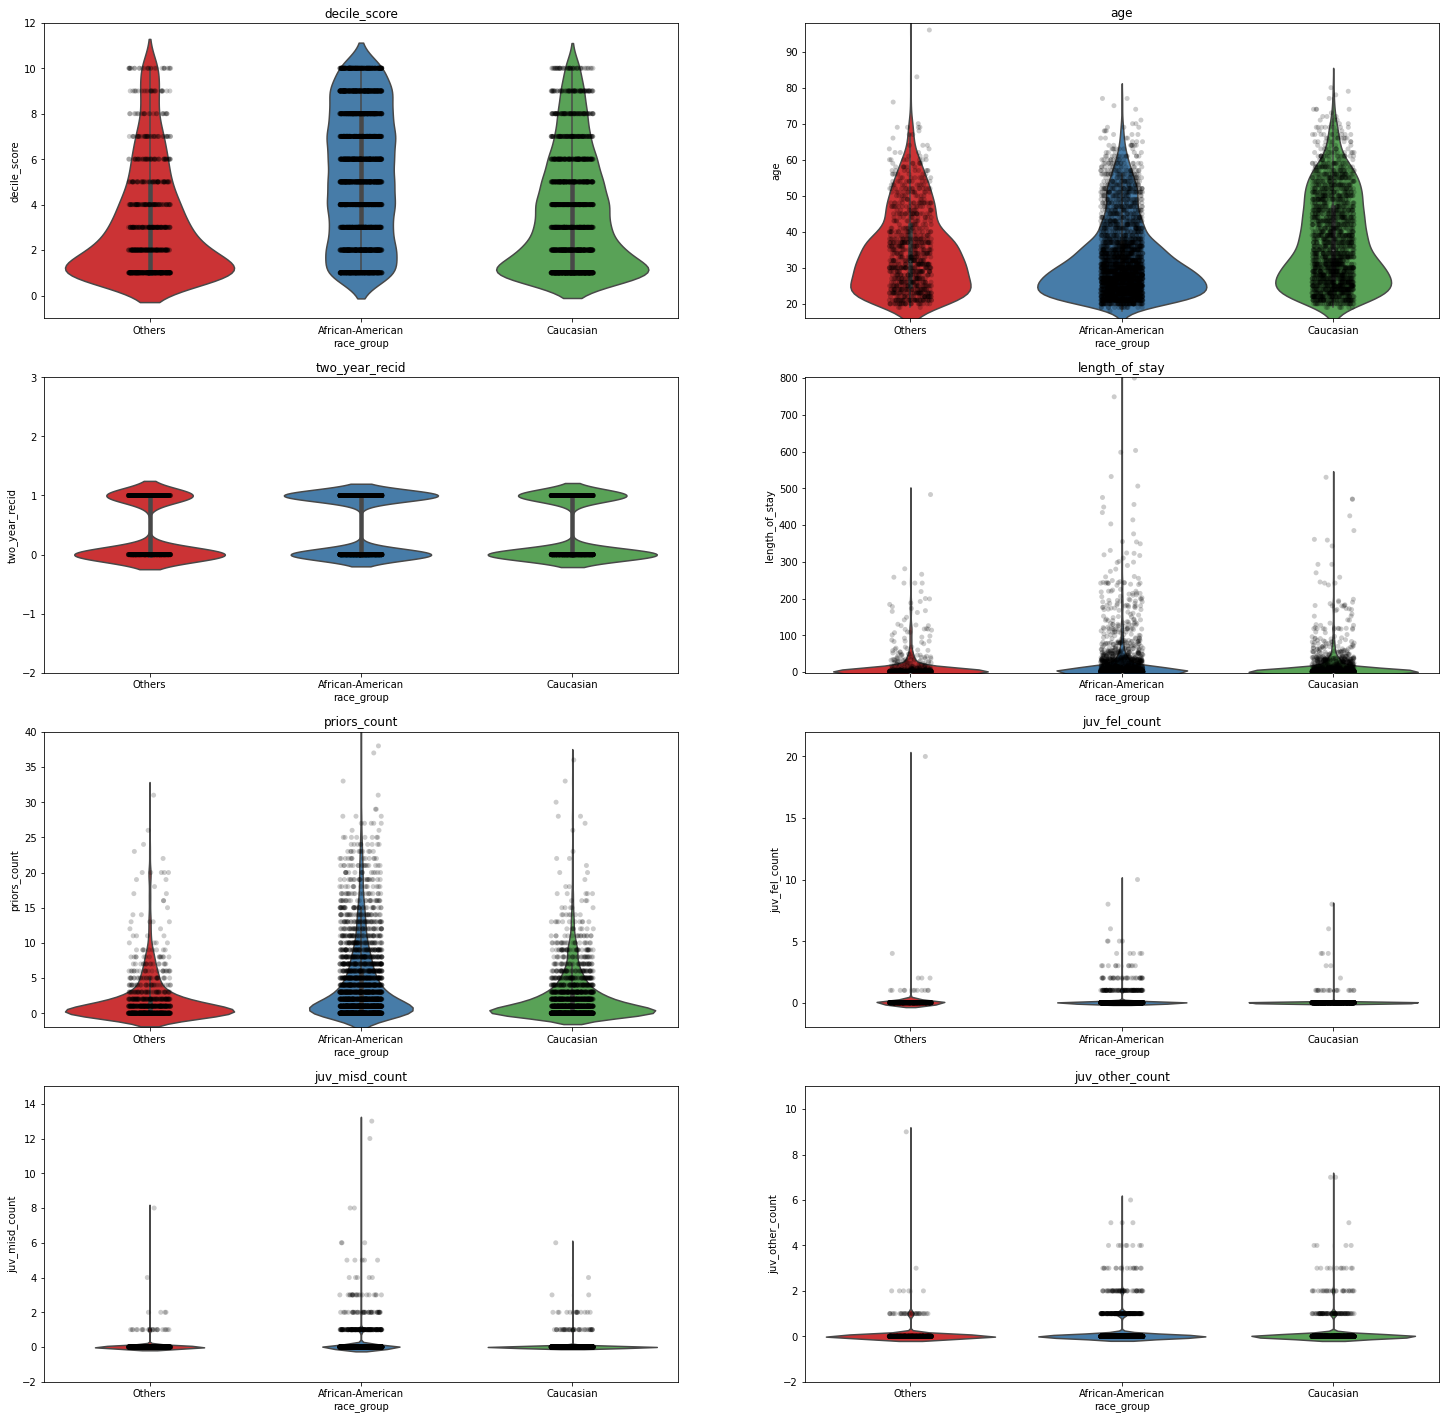

In [5]:

fig, axes = plt.subplots(4, 2, figsize = (25, 25))
axes = list(axes.flatten())

for i, col in enumerate(un_q_vars):
  sns.violinplot(x='race_group', y=col, data=df, ax = axes[i], palette="Set1", showfliers=True)
  sns.stripplot(x='race_group', y=col, data=df, ax = axes[i], jitter=True, marker='o', alpha=0.2, color='black')
  min_lim = min(df[col])-2
  max_lim = max(df[col])+2 
  axes[i].set_ylim(min_lim, max_lim)
  axes[i].set_title(col)

plt.show() 

<div class='exercise-r'>

**1.5** Based on your visuals, report which 3 variables appear to have the most significant differences between Caucasians and African Americans. Briefly interpret your findings for each of those 3 variables, being certain to explain your justification for choosing each.

**NOTE:** As illustrated by [the required readings](#intro), reporting on the U.S. Criminal Justice system often concentrates on the disparate experiences between Caucasians and African Americans, thus we have focused our approaches similarly. However, to ensure the efficacy of our models in Question 2 and Question 3, we must be certain to still keep observations for all racial groups included in our data. 

</div>

**The variables that have the most significant differences between Caucasians and African-Americans are 'decile score', 'priors_count', and 'two_year_recid'. We analyze each of these below:**

**`Decile Score`: African-Americans seem to get higher decile scores from the COMPAS algorithm. We notice that most common decile score for Caucasian defendants is 1, while the scores for African-Americans are more uniformly distributed. The violin plot reflects this too, where the Caucasian plot shows larger standard deviation near low scores which isn’t the case with African-Americans. This clearly suggests that the COMPAS algorithm predicts that more African-Americans are likely to be reoffenders after two years, than Caucasians, which is the underlying bias we are attempting to solve.**

**`Priors count`: The number of priors for African-Americans is higher on average with a larger standard deviation when compared to Caucasians. This suggests that African Americans who get arrested tend to have a larger criminal record than their Caucasian counterparts. However, we must note that systemic racism is a driver of higher arrest rates for African Americans versus Caucasians, which could be the underlying reason why their prior counts are much higher. This is again a vicious cycle, because if African Americans get wrongfully arrested more often, they will have higher prior counts and when awaiting trial, the COMPAS algorithm will predict higher recidivism likelihood based on ‘priors_count’, which serves to reinforce the existing bias due to race in the first place.**  

**`Two Year Recid`: We notice a larger number of African-Americans who have reoffended (two_year_recid = 1) than Caucasians, from the violin plot. While this finding seems to indicate (and could mean in some situations) that more African Americans are repeat offenders, we must exercise caution and keep in mind that African Americans are more likely to be arrested due to systemic racism. This means that the law enforcement could be enforcing stricter arrest conditions for African Americans than Caucasians, which leads to more former offenders being rearrested. It is interesting to note that rearresting these repeat offenders will add onto the number of priors an individual has which in the case of African Americans will be higher. This in turn will skew the COMPAS model’s prediction. Thus, an African American, once arrested, is less likely to be released due to the decile score of COMPAS and if released, could get arrested more often and subsequently jailed, due to systemic racism.**

**Additionally, we also observe some trends in the following variable:**

**`Age`: Age also appears to be a differing factor where most African Americans seem to be younger (between the ages of 25 and 30), while Caucasians seem to have a wider spread across age groups.**

<div class='exercise-r'>

**1.6** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?

</div>

**Historical and present day systems of discrimination and inequality have a direct impact on the observations in this data set. The bias in our data reflects the unfair treatment of African-Americans in our society. The fact that African-Americans have higher rates of recidivism reflects the fact that African-Americans are often unfairly targeted by police due to the false and racist perception that they pose a greater risk to society. These biased policing dynamics (racial profiling) result in disproportionate contact with the criminal justice system for African-Americans. Accordingly, it is not surprising to see the risk assessment tool (COMPAS) systematically label African-Americans as having a higher risk of recidivism than Caucasians. Higher rates of recidivism for African-Americans by definition means higher average prior counts which serves to reinforce the higher risk assessment.**




---

<a id="part2"></a>

## <div class="exercise">Question 2: Baseline modeling [21 pts]</div> 
    
[Return to contents](#contents)

**2.1**  Build a well-tuned $LASSO$-like regularized logistic regression model to predict recidivism (i.e. `two_year_recid` is your response variable). Use the following predictors: `age`, `priors_1`, `priors_234`, `priors_5plus`, `juv_fel_1plus`, `juv_misd_1plus`, `juv_other_1plus`, `charge_any_drug`, `charge_any_violence_aggression`, `charge_any_theft`, as well as your one-hot-encoded predictors for `c_charge_degree`, `sex`, and `race`. Report your resulting coefficients and interpret what this model is saying about the relationship of `two_year_recid` to `race`.


**2.2**  Report the following on the **test set**:

1. **Overall model accuracy score**


2. **False positive rates (FPR)** for each of the two groups (please note that a "positive" here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
    
    
3. **False negative rates (FNR)** for each of the two groups:
    - `African-American`
    - `Caucasian`


4. **Ratios of error rates**:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups
    - These ratios can be expressed as:

$$\frac{FPR(AA)}{FPR(CC)} \; \text{and} \; \frac{FNR(AA)}{FNR(CC)}$$


**2.3**  What do you observe? Is there any disparity in the $FPR$ and $FNR$ for the two groups? What are the implications of your findings? Explain your findings in 3-6 sentences.
    
  

<a id="part2solutions"></a>

## Question 2: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**2.1**  Build a well-tuned $LASSO$-like regularized logistic regression model to predict recidivism (i.e. `two_year_recid` is your response variable). Use the following predictors: `age`, `priors_1`, `priors_234`, `priors_5plus`, `juv_fel_1plus`, `juv_misd_1plus`, `juv_other_1plus`, `charge_any_drug`, `charge_any_violence_aggression`, `charge_any_theft`, as well as your one-hot-encoded predictors for `c_charge_degree`, `sex`, and `race`. Report your resulting coefficients and interpret what this model is saying about the relationship of `two_year_recid` to `race`.

</div>

In [6]:
# your code here

# your code here
Cs = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]
cv = 10
penalty = 'l1'
solver = 'liblinear' 

predict_subset = ['age','priors_1','priors_234', 'priors_5plus', 'juv_fel_1plus', 'juv_misd_1plus', 
                  'juv_other_1plus', 'charge_any_drug', 'charge_any_violence_aggression', 'charge_any_theft', 
                  'Race_African-American', 'Race_Asian', 'Race_Caucasian', 'Race_Hispanic', 'Race_Native American',
                  'Race_Other', 'Sex_Female', 'Sex_Male', 'Charge Degree_F', 'Charge Degree_M']

#Consider fit intercept (true or false)
logit_lasso = LogisticRegressionCV(Cs = Cs, cv = cv, penalty=penalty, solver=solver, random_state =55)
logit_lasso.fit(X_train[predict_subset], y_train)

loglasso_score_train = logit_lasso.score(X_train[predict_subset], y_train)
loglasso_score_test = logit_lasso.score(X_test[predict_subset], y_test)

display(pd.DataFrame(zip(predict_subset, logit_lasso.coef_[0]), columns = ['Feature', 'Coefficient']))

print("The Training Set Accuracy is:", str(round(loglasso_score_train*100,4))+'%')
print("The Testing Set Accuracy is:", str(round(loglasso_score_test*100,4))+'%')


,Feature,Coefficient
0,age,-2.953775
1,priors_1,0.369746
2,priors_234,0.884867
3,priors_5plus,1.714515
4,juv_fel_1plus,0.034301
5,juv_misd_1plus,0.124963
6,juv_other_1plus,0.565945
7,charge_any_drug,0.313296
8,charge_any_violence_aggression,0.157259
9,charge_any_theft,0.392278


The Training Set Accuracy is: 67.6119%
The Testing Set Accuracy is: 68.0162%


**INTERPRETATION:**

**Based on the coefficients above, the model thinks that being African-American increases the probability that an individual will recidivate, holding all else equal. On the other hand, being Caucasian decreases the probability of recidivism, all else equal. More specifically, we can say that all else equal the log odds of two-year recidivism increases by about 3% for African-American individuals. Contrast this with Caucasians whose log-odds are about 7.6% lower (all else equal).**




<div class='exercise-r'>

**2.2**  Report the following on the **test set**:

1. **Overall model accuracy score**


2. **False positive rates (FPR)** for each of the two groups (please note that a "positive" here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
    
    
3. **False negative rates (FNR)** for each of the two groups:
    - `African-American`
    - `Caucasian`


4. **Ratios of error rates**:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups
    - These ratios can be expressed as:

$$\frac{FPR(AA)}{FPR(CC)} \; \text{and} \; \frac{FNR(AA)}{FNR(CC)}$$

</div>

In [7]:
# your code here

# Get overall model accuracy score 
loglasso_score_test = logit_lasso.score(X_test[predict_subset], y_test)

ca_ind = X_test[X_test['Race_Caucasian']==1].index
aa_ind = X_test[X_test['Race_African-American']==1].index

X_test_CA = X_test[X_test['Race_Caucasian']==1][predict_subset]
X_test_AA = X_test[X_test['Race_African-American']==1][predict_subset]

y_pred_CA = logit_lasso.predict(X_test_CA)
y_pred_AA = logit_lasso.predict(X_test_AA)

confusion_CA = confusion_matrix(y_test[ca_ind], y_pred_CA)
confusion_AA = confusion_matrix(y_test[aa_ind], y_pred_AA)

tn_CA, fp_CA, fn_CA, tp_CA = confusion_CA.ravel()
tn_AA, fp_AA, fn_AA, tp_AA = confusion_AA.ravel()

# Get false positive rates 

FPR_CA = fp_CA/(fp_CA + tn_CA)
FPR_AA = fp_AA/(fp_AA + tn_AA)

# Get false negative rates

FNR_CA = fn_CA/(fn_CA + tp_CA)
FNR_AA = fn_AA/(fn_AA + tp_AA)

# Ratio of error rates 

FPR_ratio = FPR_AA/FPR_CA
FNR_ratio = FNR_AA/FNR_CA


print("The overall model accuracy score on the test set is:", str(round(loglasso_score_test*100,4))+'%\n')
print(f'The False Positive Rate (FPR) for Caucasians (CA) is {FPR_CA:.4f}.\n')
print(f'The False Positive Rate (FPR) for African-Americans (AA) is {FPR_AA:.4f}.\n')
print(f'The False Negative Rate (FNR) for Caucasians (CA) is {FNR_CA:.4f}.\n')
print(f'The False Negative Rate (FNR) for African-Americans (AA) is {FNR_AA:.4f}.\n')
print(f'The False Positive Ratio (FPR_Ratio) is {FPR_ratio:.4f}.\n')
print(f'The False Negative Ratio (FNR Ratio) is {FNR_ratio:.4f}.')

The overall model accuracy score on the test set is: 68.0162%

The False Positive Rate (FPR) for Caucasians (CA) is 0.1868.

The False Positive Rate (FPR) for African-Americans (AA) is 0.3689.

The False Negative Rate (FNR) for Caucasians (CA) is 0.5061.

The False Negative Rate (FNR) for African-Americans (AA) is 0.2761.

The False Positive Ratio (FPR_Ratio) is 1.9753.

The False Negative Ratio (FNR Ratio) is 0.5455.


<div class='exercise-r'>

**2.3**  What do you observe? Is there any disparity in the $FPR$ and $FNR$ for the two groups? What are the implications of your findings? Explain your findings in 3-6 sentences.

</div>

**Although our model is able to achieve about 68% accuracy in predicting recidivism overall, the errors that it makes are not distributed evenly among racial groups. Specifically, African-Americans are incorrectly predicted to recidivate at twice the rate of Caucasians. That is, our default classification threshold of 50% results in erroneous predictions of recidivism for 36.9% of the African-Americans, while the same is true for only 18.7% of Caucasian defendants. In other words, of the African-Americans who are predicted to reoffend, 36.9% turn out not to compared to 18.7% for Caucasians.**

**In addition to systematically overestimating African-American rates of recidivism, our model systematically underestimates the rate at which Caucasians recidivate. Our model incorrectly expects that about half of Caucasians will not reoffend even though they do, while for African-Americans only 27.6% of those predicted not to reoffend actually end up doing so.**

**Thus, our default classification threshold of 50% results in a model which makes mistakes for both races in very different ways. It reflects the bias in the data by more liberally labelling African-Americans as likely to reoffend, while giving more conservative estimates for Caucasians despite the tendency to be wrong in both cases.**

---

<a id="part3"></a>

## <div class='exercise'>Question 3: Predicting without using `race` [19 pts]</div> 
    
[Return to contents](#contents)

**3.1** Fit another well-tuned $LASSO$-like regularized logistic regression model just as you did in Question 2.1, but this time **without** `race` as a predictor. Report your resulting coefficients.

**3.2** Again, report the following on the **test set**:

1. **Overall model accuracy score**


2. **False positive rates (FPR)** for each of the two groups (please note that a "positive" here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
    
    
3. **False negative rates (FNR)** for each of the two groups:
    - `African-American`
    - `Caucasian`


4. **Ratios of error rates**:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups
    - These ratios can be expressed as:

$$\frac{FPR(AA)}{FPR(CC)} \; \text{and} \; \frac{FNR(AA)}{FNR(CC)}$$


**3.3**  How do these metrics compare to the model when the variable `race` **is** included as a predictor?

**3.4**  Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not? Give careful consideration to why the bias is still occurring or not still occurring in your results and what the real-life implications/effects might be for such a tool.

<a id="part3solutions"></a>

## Question 3: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**3.1** Fit another well-tuned $LASSO$-like regularized logistic regression model just as you did in Question 2.1, but this time **without** `race` as a predictor. Report your resulting coefficients.

</div>

In [8]:
# your code here
Cs = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]
cv = 10
penalty = 'l1'
solver = 'liblinear' 

predict_subset_norace = ['age','priors_1','priors_234', 'priors_5plus', 'juv_fel_1plus', 'juv_misd_1plus', 'juv_other_1plus', 'charge_any_drug', 'charge_any_violence_aggression', 'charge_any_theft', 
       'Sex_Female', 'Sex_Male', 'Charge Degree_F', 'Charge Degree_M']

logit_lasso_norace = LogisticRegressionCV(Cs = Cs, cv = cv, penalty=penalty, solver=solver)
logit_lasso_norace.fit(X_train[predict_subset_norace], y_train)

loglasso_score_train = logit_lasso_norace.score(X_train[predict_subset_norace], y_train)
loglasso_score_test = logit_lasso_norace.score(X_test[predict_subset_norace], y_test)

display(pd.DataFrame(zip(predict_subset_norace, logit_lasso_norace.coef_[0]), columns = ['Feature', 'Coefficient']))

print("The training set accuracy for our model without race:", str(round(loglasso_score_train*100, 4))+'%')
print("The testing set accuracy for our model without race:", str(round(loglasso_score_test*100, 4))+'%')


,Feature,Coefficient
0,age,-3.015459
1,priors_1,0.382487
2,priors_234,0.903627
3,priors_5plus,1.755498
4,juv_fel_1plus,0.053187
5,juv_misd_1plus,0.140788
6,juv_other_1plus,0.565800
7,charge_any_drug,0.317393
8,charge_any_violence_aggression,0.155842
9,charge_any_theft,0.392752


The training set accuracy for our model without race: 67.7537%
The testing set accuracy for our model without race: 68.2591%


<div class='exercise-r'>

**3.2** Again, report the following on the **test set**:

1. **Overall model accuracy score**


2. **False positive rates (FPR)** for each of the two groups (please note that a "positive" here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
    
    
3. **False negative rates (FNR)** for each of the two groups:
    - `African-American`
    - `Caucasian`


4. **Ratios of error rates**:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups
    - These ratios can be expressed as:

$$\frac{FPR(AA)}{FPR(CC)} \; \text{and} \; \frac{FNR(AA)}{FNR(CC)}$$

</div>

In [9]:
# your code here

# Get overall model accuracy score 
loglasso_score_test = logit_lasso_norace.score(X_test[predict_subset_norace], y_test)

y_pred_CA = logit_lasso_norace.predict(X_test[predict_subset_norace])[ca_ind]
y_pred_AA = logit_lasso_norace.predict(X_test[predict_subset_norace])[aa_ind]

# Generate confusion matrices to make error calculations easier 

confusion_CA = confusion_matrix(y_test[ca_ind], y_pred_CA)
confusion_AA = confusion_matrix(y_test[aa_ind], y_pred_AA)

tn_CA, fp_CA, fn_CA, tp_CA = confusion_CA.ravel()
tn_AA, fp_AA, fn_AA, tp_AA = confusion_AA.ravel()

# Get false positive rates 

FPR_CA = fp_CA/(fp_CA + tn_CA)
FPR_AA = fp_AA/(fp_AA + tn_AA)

# Get false negative rates

FNR_CA = fn_CA/(fn_CA + tp_CA)
FNR_AA = fn_AA/(fn_AA + tp_AA)

# Ratio of error rates 

FPR_ratio = FPR_AA/FPR_CA
FNR_ratio = FNR_AA/FNR_CA

print("The overall model accuracy score on the test set is:", str(round(loglasso_score_test*100,4))+'%\n')
print(f'The False Positive Rate (FPR) for Caucasians (CA) is {FPR_CA:.4f}.\n')
print(f'The False Positive Rate (FPR) for African-Americans (AA) is {FPR_AA:.4f}.\n')
print(f'The False Negative Rate (FNR) for Caucasians (CA) is {FNR_CA:.4f}.\n')
print(f'The False Negative Rate (FNR) for African-Americans (AA) is {FNR_AA:.4f}.\n')
print(f'The False Positive Ratio (FPR_Ratio) is {FPR_ratio:.4f}.\n')
print(f'The False Negative Ratio (FNR Ratio) is {FNR_ratio:.4f}.')

The overall model accuracy score on the test set is: 68.2591%

The False Positive Rate (FPR) for Caucasians (CA) is 0.2062.

The False Positive Rate (FPR) for African-Americans (AA) is 0.3333.

The False Negative Rate (FNR) for Caucasians (CA) is 0.4817.

The False Negative Rate (FNR) for African-Americans (AA) is 0.3037.

The False Positive Ratio (FPR_Ratio) is 1.6164.

The False Negative Ratio (FNR Ratio) is 0.6304.


<div class='exercise-r'>

**3.3**  How do these metrics compare to the model when the variable `race` **is** included as a predictor?

</div>

**Although less extreme than the case in which we include race as a predictor, this model still systematically overestimates recidivisim for African-Americans and underestimates it for Caucasians. In this model, the FPR Ratio goes down slightly and the FNR Ratio goes up slightly. Even though race is not explicitly included as a predictor, it has many predictors which are highly correlated with it, such as 'priors_count' as confirmed by the violin plots in 1.4. Such correlated predictors are included in the model resulting in biases that are very similar to the model that includes race. Similarly, the COMPAS model is also known to not include race as a predictor (as required by American law) but still produces biased predictions.**



<div class='exercise-r'>

**3.4**  Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not? Give careful consideration to why the bias is still occurring or not still occurring in your results and what the real-life implications/effects might be for such a tool.

</div>

**A predictive tool cannot be trusted to be unbiased even if it doesn’t explicitly include a bias-inducing variable such as race. This is because systemic bias exists in society and the training data reflects this underlying ground truth, which means that racism unfortunately seeps into the data in the form of other predictors. These predictors are understandably highly correlated with race. Training data is merely a sampled reflection of reality and unless the ground truth in society sees a shift in racism and its treatment, it is impossible to expect the training data to reflect a different truth by simply removing race as a predictor. In this way, the influence of race on outcomes in the criminal justice system still finds its way into our model. Even if the driver of bias is not directly present in the dataset, its influence still is.** 

**The real life implications of using such a tool are that we tend to trust an algorithm blindly because we deem it to be devoid of human biases when in fact the model has imbibed all the same biases and is spitting out predictions which reinforce existing societal racism. African-Americans as a whole are unfairly targeted due to the judge’s decision (to imprison or release them) being affected by a tool such as COMPAS. It is important to note the reinforcing nature of such biased model predictions and this warrants caution, careful checking and correction for their impact on our end, when we frame our question and train our model.**

---

<a id="part4"></a>

## <div class='exercise'>Question 4: Classification thresholds and fairness [34 pts]</div> 
    
[Return to contents](#contents)

**4.1** Use the logistic regression model from Question 3.1 and plot the Receiver Operating Characteristic (ROC) curves for two racial groups: `African-American` and `Caucasian` in the **training set**.
    
**4.2** The default threshold used for determining the classification metrics analyzed in Question 2.2 and Question 3.2 was $\hat{p}=0.5$.  Choose a new single threshold for the model from Question 3.1 that will reduce the bias between these two racial groups as measured by the "Ratios of Error Rates" (as defined by the formulas shown in Question 3.2). Be certain to justify your choice and interpet how this threshold choice affects your model results.

**HINT:** There is no one correct answer here. However, to arrive at an answer you can support with an evidence-based justification, you will likely need to inspect the "Ratio of $FPR$", "Ratio of $FNR$", and accuracy trends across varying classification thresholds. There should be no need to refit your model from Question 3.1 to accomplish this task.

**4.3** A second approach to reducing bias is to use different thresholds for the different racial groups to better ensure that the individual groups have similar false positive and false negative rates.  Choose a pair of thresholds (one for the `African-American` group and one for the `Caucasian` group) that improves the group bias (while still taking accuracy into consideration). Be certain to justify your choices and interpet how these threshold choices affect your model results.

**HINT:** To arrive at an answer you can support with an evidence-based justification, you will likely need to inspect $FPR$, $FNR$, and accuracy trends across varying classification thresholds for each group (`African-American` and `Caucasian`) individually. There should be no need to refit your model from Question 3.1 to accomplish this task.

**4.4** Comment on [the fairness](<https://en.wikipedia.org/wiki/Fairness_(machine_learning)>) of the two methods in Question 4.2 and Question 4.3 from two different perspectives: the fairness of each group (called "group fairness") and the fairness for an individual defendant (called "individual fairness"). 

**4.5** Changing the thresholds can *reduce* bias between the two classes, but it can also affect model accuracy. We want our model to be **accurate** but also **fair**.  What can be done to balance these two criteria?  Write down your strategy to overcome this difficulty. Please limit your response to at most 150 words.  
     

<a id="part4solutions"></a>

## Question 4: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**4.1** Use the logistic regression model from Question 3.1 and plot the Receiver Operating Characteristic (ROC) curves for two racial groups: `African-American` and `Caucasian` in the **training set**.

</div>

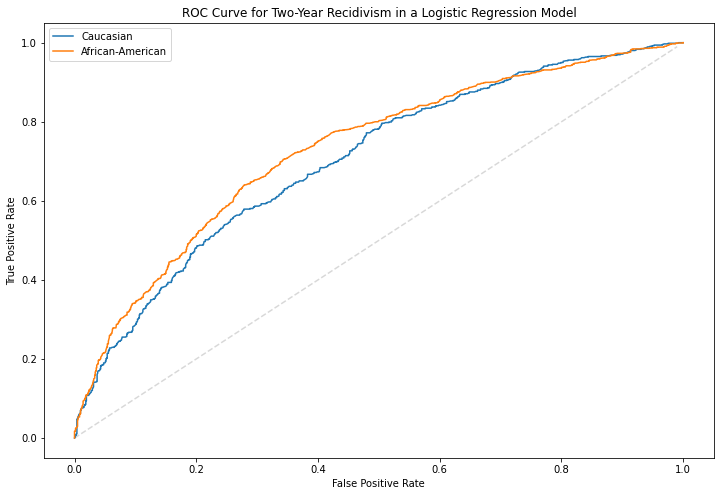

In [10]:
# your code here

X_train_CA = X_train[X_train['Race_Caucasian']==1][predict_subset_norace]
X_train_AA = X_train[X_train['Race_African-American']==1][predict_subset_norace]

yhat_CA= logit_lasso_norace.predict_proba(X_train_CA)[:,1]
yhat_AA = logit_lasso_norace.predict_proba(X_train_AA)[:,1]

fpr_CA, tpr_CA, thresholds_CA = roc_curve(y_train[X_train_CA.index], yhat_CA)
fpr_AA, tpr_AA, thresholds_AA = roc_curve(y_train[X_train_AA.index], yhat_AA)

x = np.arange(0,100)/100
plt.figure(figsize = (12,8))
plt.plot(x, x, '--', color="gray", alpha=0.3)
plt.plot(fpr_CA, tpr_CA, label="Caucasian")
plt.plot(fpr_AA, tpr_AA, label="African-American")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve for Two-Year Recidivism in a Logistic Regression Model")
plt.legend()
plt.show()




<div class='exercise-r'>

**4.2** The default threshold used for determining the classification metrics analyzed in Question 2.2 and Question 3.2 was $\hat{p}=0.5$.  Choose a new single threshold for the model from Question 3.1 that will reduce the bias between these two racial groups as measured by the "Ratios of Error Rates" (as defined by the formulas shown in Question 3.2). Be certain to justify your choice and interpet how this threshold choice affects your model results.

**HINT:** There is no one correct answer here. However, to arrive at an answer you can support with an evidence-based justification, you will likely need to inspect the "Ratio of $FPR$", "Ratio of $FNR$", and accuracy trends across varying classification thresholds. There should be no need to refit your model from Question 3.1 to accomplish this task.

</div>

In [11]:
# Note: We get runtime warnings because we see division by 0 (NaN values) in our (fpr, fnr tpr and tnr) values.
# We suppress these warnings below and display the NaN values for better understanding of the model's predictions

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

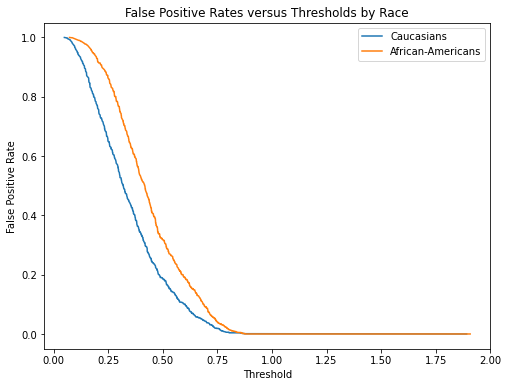

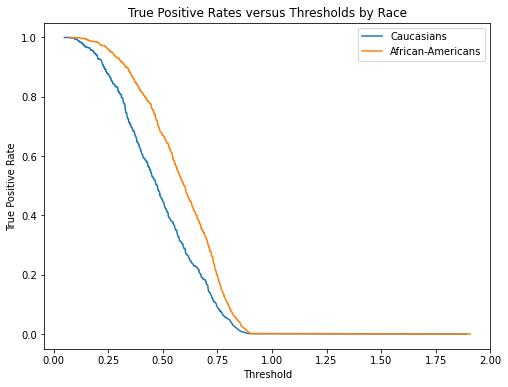

In [12]:
# your code here

plt.figure(figsize = (8,6))
plt.title('False Positive Rates versus Thresholds by Race')
plt.plot(thresholds_CA, fpr_CA, label = 'Caucasians')
plt.plot(thresholds_AA, fpr_AA, label = 'African-Americans')
plt.ylabel("False Positive Rate")
plt.xlabel("Threshold")
plt.legend()
plt.plot()


plt.figure(figsize = (8,6))
plt.title('True Positive Rates versus Thresholds by Race')
plt.plot(thresholds_CA, tpr_CA, label = 'Caucasians')
plt.plot(thresholds_AA, tpr_AA, label = 'African-Americans')
plt.ylabel("True Positive Rate")
plt.xlabel("Threshold")
plt.legend()
plt.plot()

threshdict = {}
thresholds = np.linspace(0,1,101)

confusion_CA = confusion_matrix(y_pred_CA, y_test[X_test_CA.index])
confusion_AA = confusion_matrix(y_pred_AA, y_test[X_test_AA.index])

yhat = logit_lasso_norace.predict_proba(X_test[predict_subset_norace])[:,1]

threshdict = {}
threshdict_extra = {}

for i in thresholds_CA:
    
    ypred_val = pd.DataFrame([1 if prob >= i else 0 for prob in yhat])
    
    CA_cm = confusion_matrix(y_test[ca_ind], np.array(ypred_val)[ca_ind]) 
    AA_cm = confusion_matrix(y_test[aa_ind], np.array(ypred_val)[aa_ind])
    
    tn_CA, fp_CA, fn_CA, tp_CA = CA_cm.ravel()
    tn_AA, fp_AA, fn_AA, tp_AA = AA_cm.ravel()
    
    fpr_AA = fp_AA/(fp_AA + tn_AA)
    fpr_CA = fp_CA/(fp_CA + tn_CA)
    
    fnr_AA = fn_AA/(fn_AA + tp_AA)
    fnr_CA = fn_CA/(fn_CA + tp_CA)
    
    test_acc = round(accuracy_score(y_test, ypred_val), 4)
    
    threshdict[i] = [fpr_AA/fpr_CA, fnr_AA/fnr_CA, test_acc]

    # For additional plotting
    threshdict_extra[i] = [fpr_AA/fpr_CA, fnr_AA/fnr_CA, (tn_CA, fp_CA, fn_CA, tp_CA), (tn_AA, fp_AA, fn_AA, tp_AA), test_acc, fnr_AA, fnr_CA, fpr_AA, fpr_CA]

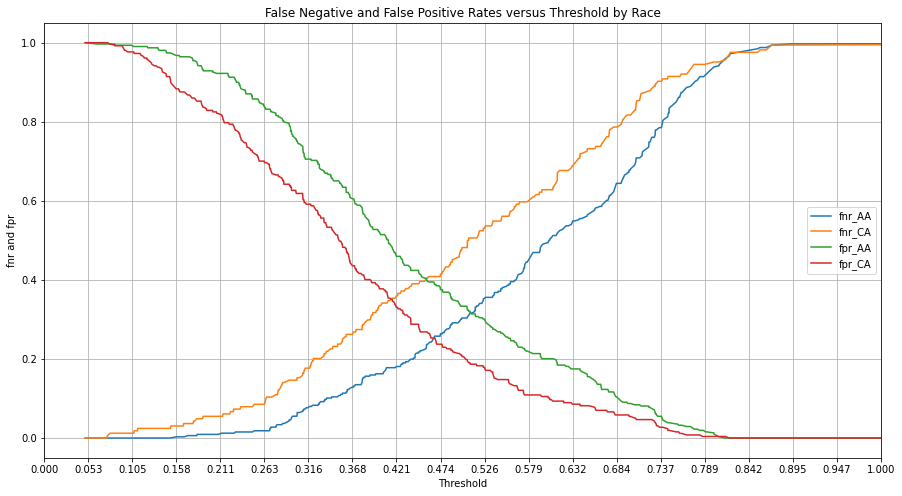

In [13]:
thresh_frame_1 = pd.DataFrame.from_dict(threshdict_extra, orient = 'index', columns = ['FP_ratio', 'FN_ratio','CA Errors (tn, fp, fn, tp)', 'AA Errors (tn, fp, fn, tp)','Test_acc', 'fnr_AA', 'fnr_CA', 'fpr_AA', 'fpr_CA'])

ax = thresh_frame_1.plot(y = ['fnr_AA', 'fnr_CA', 'fpr_AA', 'fpr_CA'], xlim = (0,1), use_index = True, grid = True, xticks = np.linspace(0,1,20), figsize = (15,8));
ax.set_xlabel('Threshold') 
ax.set_ylabel('fnr and fpr')
plt.title("False Negative and False Positive Rates versus Threshold by Race")
plt.show()

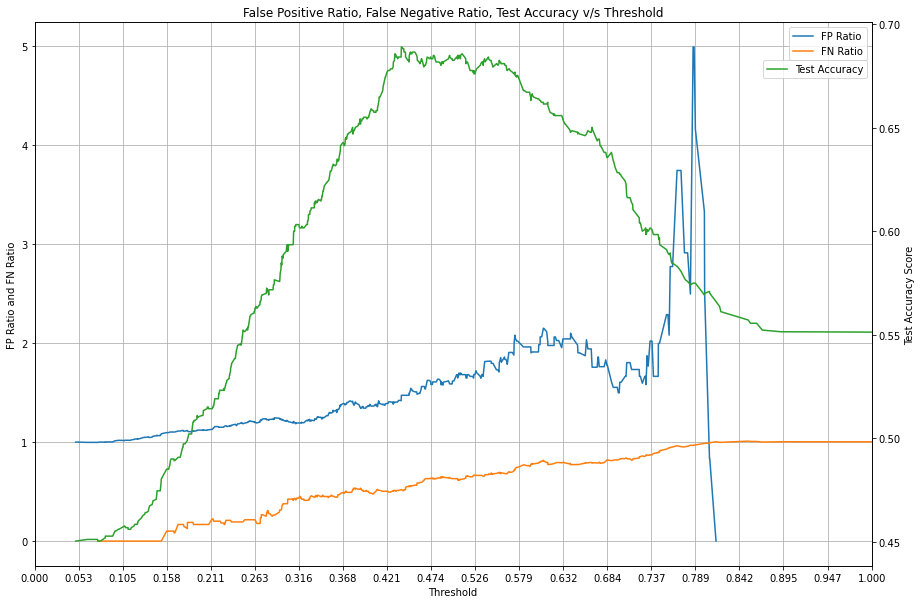

,FP_ratio,FN_ratio,"CA Errors (tn, fp, fn, tp)","AA Errors (tn, fp, fn, tp)",Test_acc,fnr_AA,fnr_CA,fpr_AA,fpr_CA
0.814145,0.000000,1.002931,"(256, 1, 157, 7)","(309, 0, 313, 13)",0.5660,0.960123,0.957317,0.000000,0.003891
0.806672,0.831715,0.993236,"(256, 1, 156, 8)","(308, 1, 308, 18)",0.5700,0.944785,0.951220,0.003236,0.003891
0.806366,0.831715,0.990011,"(256, 1, 156, 8)","(308, 1, 307, 19)",0.5709,0.941718,0.951220,0.003236,0.003891
0.063413,0.996764,NaN,"(0, 257, 0, 164)","(1, 308, 0, 326)",0.4510,0.000000,0.000000,0.996764,1.000000
0.075404,0.996764,NaN,"(0, 257, 0, 164)","(1, 308, 0, 326)",0.4510,0.000000,0.000000,0.996764,1.000000
0.075488,0.996764,0.000000,"(0, 257, 1, 163)","(1, 308, 0, 326)",0.4502,0.000000,0.006098,0.996764,1.000000
0.075909,0.996764,0.000000,"(0, 257, 1, 163)","(1, 308, 0, 326)",0.4502,0.000000,0.006098,0.996764,1.000000
0.062986,0.996764,NaN,"(0, 257, 0, 164)","(1, 308, 0, 326)",0.4510,0.000000,0.000000,0.996764,1.000000
0.084456,0.997408,0.000000,"(1, 256, 2, 162)","(2, 307, 0, 326)",0.4518,0.000000,0.012195,0.993528,0.996109
0.049117,1.000000,NaN,"(0, 257, 0, 164)","(0, 309, 0, 326)",0.4502,0.000000,0.000000,1.000000,1.000000


In [14]:
thresh_frame_2 = pd.DataFrame.from_dict(threshdict_extra, orient = 'index', columns = ['FP_ratio', 'FN_ratio','CA Errors (tn, fp, fn, tp)', 'AA Errors (tn, fp, fn, tp)','Test_acc', 'fnr_AA', 'fnr_CA', 'fpr_AA', 'fpr_CA'])

#         Threshold FP_ratio	FN_ratio	Test_acc
#Best FP: 0.806364	1.000000	1.967949	57.0
#Best FN: 0.167641	1.324444	0.166667	49.0

ax = thresh_frame_2.plot(y=['FP_ratio', 'FN_ratio', 'Test_acc'], xlim = (0,1), secondary_y= 'Test_acc', use_index=True, grid = True, xticks = np.linspace(0,1,20), figsize = (15,10))
ax.set_xlabel('Threshold') 
ax.set_ylabel('FP Ratio and FN Ratio')
ax.right_ax.set_ylabel("Test Accuracy Score")
ax.legend(["FP Ratio", "FN Ratio"])
ax.right_ax.legend(["Test Accuracy"], bbox_to_anchor=(0.87, 0.93), loc='upper left', borderaxespad=0)
plt.title("False Positive Ratio, False Negative Ratio, Test Accuracy v/s Threshold")
plt.show()

# Printing the first ten sorted FP_Ratio values to check our options
display(thresh_frame_2.sort_values(by = ['FP_ratio'], ascending = True).iloc[:10])


**We display the first 10 rows of our dataframe sorted by FP Ratio in order to illustrate that picking an extreme threshold like 0.8 may help reduce bias but compromise severely on accuracy.**

**We now plot everything together, to see all relationships in one place.**

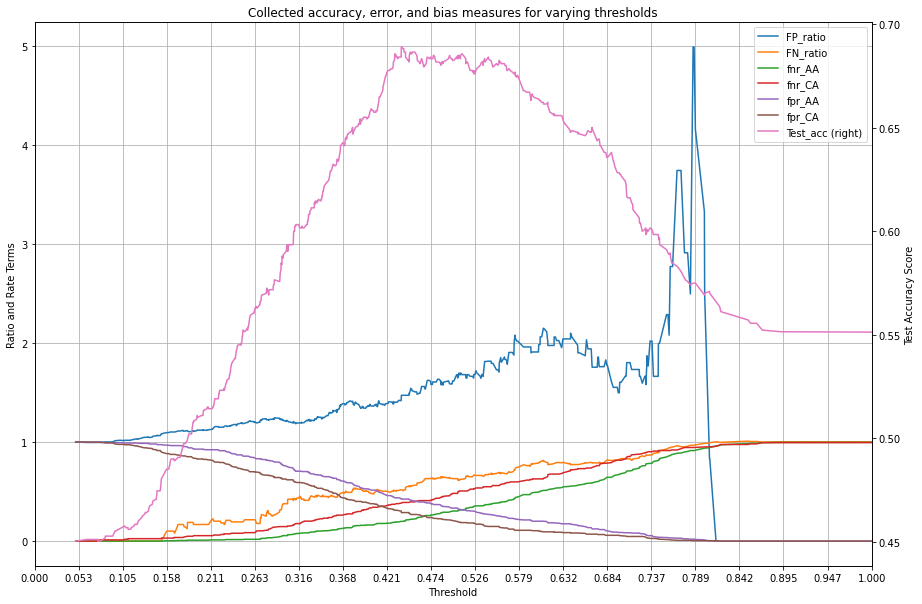

In [15]:
thresh_frame_3 = pd.DataFrame.from_dict(threshdict_extra, orient = 'index', columns = ['FP_ratio', 'FN_ratio','CA Errors (tn, fp, fn, tp)', 'AA Errors (tn, fp, fn, tp)','Test_acc', 'fnr_AA', 'fnr_CA', 'fpr_AA', 'fpr_CA'])

ax = thresh_frame_3.plot(y = ['FP_ratio', 'FN_ratio', 'fnr_AA', 'fnr_CA', 'fpr_AA', 'fpr_CA', 'Test_acc'], xlim = (0,1), secondary_y= 'Test_acc', use_index = True, grid = True, xticks = np.linspace(0,1,20), figsize = (15,10))
ax.set_xlabel('Threshold') 
ax.set_ylabel('Ratio and Rate Terms')
ax.right_ax.set_ylabel("Test Accuracy Score")
ax.set_title("Collected accuracy, error, and bias measures for varying thresholds")
plt.show()


**INTERPRETATION:**

**We seek a classification threshold that reduces racial bias with minimal impact on overall classification accuracy. Unfortunately, due to the structural nature of racism in American society it is impossible to obtain a threshold that eliminates all traces of racial bias unless we disregard model accuracy altogether which defeats the purpose of modeling in the first place. Despite this fact, we can do better (that is reduce bias with reasonable impact on accuracy) than the results we obtained by using the default p = 0.5 classification threshold. We measure the racial bias of our classifier by dividing the African-American misclassification rates (false positive rate and false negative rate) by the Caucasian misclassification rates and call these new metrics 'False Positive Ratio' and 'False Negative Ratio', respectively. The results that we observe paint an upsetting yet unsurprising picture of the criminal justice system in the United States. Namely, we see that the false positive ratio is larger than one for almost all reasonable threshold values. Put another way, no matter which threshold we choose, we will almost always incorrectly predict that African-Americans will re-offend at a higher rate than Caucasians. It is impossible to eliminate the imbalance in false positive rates among the two races unless we choose a threshold that predicts almost everyone or no one  will reoffend and therefore have a very inaccurate model as a result. We observe a similar dynamic with the ratio of false negative rates whereby we systematically underestimate the rate at which Caucasians will reoffend relative to African-Americans. With all of this in mind, we choose 0.421 as our recommended classification threshold as it reduces racial bias as measured by the false positive ratio while holding overall accuracy almost constant. The tradeoff here is that the false negative ratio also goes down, meaning that our model is now more prone to let a dangerous Caucasian walk free than it was before. However, in our opinion it is worse to wrongfully incarcerate a person who is not a threat to society than it is to free a person who will ultimately reoffend. In accordance with this value system, we prioritize reducing the false positive ratio and maintaining overall model accuracy. Although we could achieve a similar false positive ratio and also increase the false negative ratio by choosing a threshold around 0.7, this would come at too great an expense to overall model accuracy as the share of false negatives increases and the share of false positives decreases.**

<div class='exercise-r'>

**4.3** A second approach to reducing bias is to use different thresholds for the different racial groups to better ensure that the individual groups have similar false positive and false negative rates.  Choose a pair of thresholds (one for the `African-American` group and one for the `Caucasian` group) that improves the group bias (while still taking accuracy into consideration). Be certain to justify your choices and interpet how these threshold choices affect your model results.

**HINT:** To arrive at an answer you can support with an evidence-based justification, you will likely need to inspect $FPR$, $FNR$, and accuracy trends across varying classification thresholds for each group (`African-American` and `Caucasian`) individually. There should be no need to refit your model from Question 3.1 to accomplish this task.

</div>

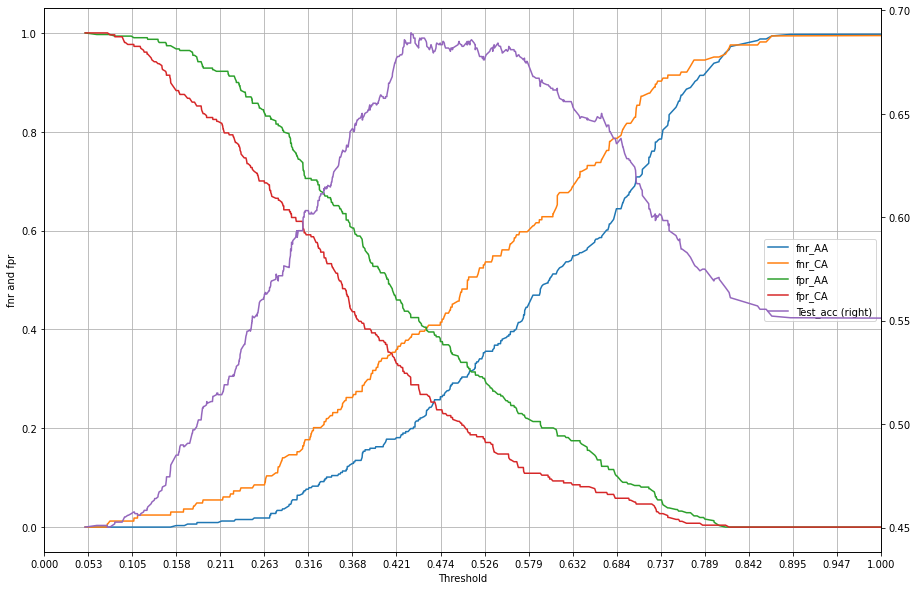

In [16]:
# your code here
# replotting the plot from earlier, since it is relevant here. Including accuracy for analysis.

thresh_frame_4 = pd.DataFrame.from_dict(threshdict_extra, orient = 'index', columns = ['FP_ratio', 'FN_ratio','CA Errors (tn, fp, fn, tp)', 'AA Errors (tn, fp, fn, tp)','Test_acc', 'fnr_AA', 'fnr_CA', 'fpr_AA', 'fpr_CA'])

ax = thresh_frame_4.plot(y = ['fnr_AA', 'fnr_CA', 'fpr_AA', 'fpr_CA', 'Test_acc'], xlim = (0,1), secondary_y= 'Test_acc', use_index = True, grid = True, xticks = np.linspace(0,1,20), figsize = (15,10))
ax.set_xlabel('Threshold') 
ax.set_ylabel('fnr and fpr')
plt.show()


**INTERPRETATION:**

**Ideally, we would like to eliminate bias by picking the threshold that gives us the lowest value of fpr for African-Americans and lowest value of fnr for Caucasians as possible while maintaining reasonable model accuracy, because our model introduces bias with these two parameters. This means we would want to pick a threshold that minimizes fpr_AA (green line) and minimizes fnr_CA (orange line). However, picking thresholds this way would adversely impact the model accuracy and introduce bias against Caucasians.**

**Instead, in order to maintain similar false positive and false negative rates for both groups, we choose a higher threshold for African-Americans to compensate for the systemic bias and racism that they regularly face. In other words, we are enforcing a condition that there should be more certainty (higher threshold) before we classify an African-American as guilty. We put more emphasis on minimizing false positives for African-Americans (fpr_AA) due to the fact that they make up a larger percentage of the inmate population. A larger fpr_AA means we are falsely convicting more African-Americans. The ethical principle that is important to us is the fact that it is worse to wrongfully incarcerate a person who is not a threat to society than it is to let free a person who will ultimately reoffend.**

**In keeping with this reasoning, we choose a threshold of 0.526 for Caucasians and 0.632 for African-Americans. The false-positive rate is about 0.19 for both groups and the false-negative rate is roughly 0.55. We also note that the green & red lines (fpr) and blue & orange lines (fnr) give roughly same values for this range, which also motivated this choice. Accuracy sees a sharp dip beyond 0.632 which is why we cap our range of threshold considerations there. It is important to acknowledge that while our choice accounts for fpr and accuracy, we must compromise on fnr, which increases. As per our ethical principle outlined earlier, this is the tradeoff we are willing to make to allow for a more unbiased treatment of the two groups.**

<div class='exercise-r'>

**4.4** Comment on [the fairness](<https://en.wikipedia.org/wiki/Fairness_(machine_learning)>) of the two methods in Question 4.2 and Question 4.3 from two different perspectives: the fairness of each group (called "group fairness") and the fairness for an individual defendant (called "individual fairness"). 

</div>

**We consider fairness as the idea of equitable treatment of two parties. Thus, group fairness is the notion of holding two groups to the same standard and individual fairness is the notion of holding two individuals to the same standard. In 4.2, we choose a single threshold, which demonstrates that we cannot achieve group fairness because there is no single threshold in the plot which gives similar false-positive and/or false-negative rates for both groups. At an individual level, we enforce the same threshold regardless of race, hence there is fair treatment for any two individuals of different races. Choosing two thresholds in 4.3 opens up doors for treating both groups fairly because we enforce similar values of false-negative rates and false-positive rates. However, from an individual standpoint, we are considering race when determining that individual's threshold which is unfair on an individual level though it helps the group as a whole.**

**In conclusion, if we want group fairness, we have to hold individuals to different standards and if we want individual fairness, we can no longer achieve group fairness. Attempting to enforce individual fairness results in biased outcomes for African-Americans as a group, due to racism.**

<div class='exercise-r'>

**4.5** Changing the thresholds can *reduce* bias between the two classes, but it can also affect model accuracy. We want our model to be **accurate** but also **fair**.  What can be done to balance these two criteria?  Write down your strategy to overcome this difficulty. Please limit your response to at most 150 words.  

</div>

**Our goal is to build a model which is both accurate and fair. One solution that has worked in some areas such as healthcare (predicting likelihood of developing breast cancer through scans - eg. research by Prof. Regina Barzilay, MIT) is the idea of fixing the bias in the training data by making it more diverse. If the model sees a less biased ground truth when training, it is less likely to make biased predictions. In a field like healthcare, we can do this by collecting diverse patient information, but how can one make criminal data more diverse?**

**To tackle this, we propose the following strategy. First, we will use two thresholds to reduce bias in the model. This should bring down the risk assessment scores for African-Americans and release fewer guilty Caucasians. We now use these defendants (originally test data with risk scores) to train our model again. This time, the model will be trained with inherently less biased data. We now test this freshly trained model on a new batch of defendants awaiting trial (new test dataset). We can rinse and repeat this train-test process by reassigning test data as training data, until we see a more diverse dataset.**

**We are aware that using test data to retrain a model is not recommended because model performance is always evaluated on unseen data. Our strategy is not ideal but we believe that because only those defendants who recidivate will re-enter the system and since the model would have been retrained several times before retesting on these repeat offenders, it will not overfit to these observations.**

**Striking a balance between fairness and accuracy is an active area of research even today, with proposed solutions leveraging reinforcement learning, confidence-based approaches, etc.**

#### THE END

[Return to contents](#contents)